# Import packages

In [43]:
import os
# import requests
# import networkx as nx
# import pandas as pd
# import geopandas as gpd
# from pyvis.network import Network
# import openai
from IPython.display import display, HTML, Code
from IPython.display import clear_output

In [44]:
# %load_ext autoreload
# %autoreload 2

import LLM_Geo_Constants as constants
import helper
# import LLM_Geo_kernel.Solution as Solution

from LLM_Geo_kernel import Solution

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
# Case 1: population living near hazardous wastes

# task_name ='Resident_at_risk_counting'

# TASK = r"""1) Find out the total population that lives within a tract that contain hazardous waste facilities. The study area is North Carolina, US.
# 2) Generate a map to show the spatial distribution of population at the tract level and highlight the borders of tracts that have hazardous waste facilitiesm, also show the facility location.
# """
# DATA_LOCATIONS = ["NC hazardous waste facility ESRI shape file location: https://github.com/gladcolor/LLM- Geo/raw/master/overlay_analysis/Hazardous_Waste_Sites.zip.",
#                   "NC tract boundary shapefile location: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_shp_37.zip. The tract id column is 'Tract'.",
#                   "NC tract population CSV file location: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/NC_tract_population.csv. The population is stored in 'TotalPopulation' column. The tract ID column is 'GEOID'."
#                  ]

#Case 2: France_mobility_changes_2020
task_name ='France_mobility_changes_2020'
TASK = r'''
1) Show the 2020 human mobility monthly change rates of each administrative regions in a France map. Each month is a sub-map in a map matrix. The base of the change rate is January 2020. 
2) Draw a line chart to show the monthly change rate trends of all administrative regeions. Each region is a line, the x-axis is 2020 months.
'''

DATA_LOCATIONS = ["ESRI shapefile for France administrative regions:" + \
                  "https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip. " + \
                  "The 'GID_1' column is the administrative region code, 'NAME_1' column is the administrative region name.",
                  "REST API url with parameters for human mobility data access:" + \
                  "http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin=01/01/2020&end=12/31/2020." + \
                  "The response is in CSV format. There are three columns in the response: " + \
                  "place,date (format:2020-01-07), and intra_movement. 'place' column is the administractive region code of every country; codes for France administrative regions start with 'FRA'.",
                 ]


# # Case 3: COVID-19 prevalence trend
# task_name ='COVID_death_rate'
# TASK = r'''1) Draw a map to show the death rate (death/case) of COVID-19 among the countiguous US counties. Use the accumulated COVID-19 data of 2020.12.31 to compute the death rate. Use scheme ='quantiles' when plotting the map.  Set map projection to 'Conus Albers'. Set map size to 15*10 inches.  
# 2) Draw a scatter plot to show the correlation and trend line of the death rate with the senior resident rate, including the r-square and p-value. Set data point transparency to 50%, regression line as red.  Set figure size to 15*10 inches.  
# '''

# DATA_LOCATIONS = [
#                   r"COVID-19 data case in 2020 (county-level): https://github.com/nytimes/covid-19-data/raw/master/us-counties-2020.csv. This data is for daily accumulated COVID cases and deaths for each county in the US. There are 5 columns: date (format: 2021-02-01), county, state, fips, cases, deaths. ",   
#                   r"Contiguous US county boundary (ESRI shapefile): https://github.com/gladcolor/spatial_data/raw/master/contiguous_counties.zip. The county FIPS column is 'GEOID'. ",
#                   r"Census data (ACS2020): https://raw.githubusercontent.com/gladcolor/spatial_data/master/Demography/ACS2020_5year_county.csv. THe needed columns are: 'FIPS', 'Total Population', 'Total Population: 65 to 74 Years', 'Total Population: 75 to 84 Years', 'Total Population: 85 Years and Over'. Drop rows with NaN cells after loading the used columns.",
#                  ]

 
# Case 4: Hospital_accessibility
# task_name ='Hospital_accessibility'

# TASK = r'''
# For each zipcode area in South Carolina (SC), calculate the distance from the centroid of the zipcode area to its nearest hospital, and then create a choropleth distance map (unit: km), also show the hospital.
# '''

# # TASK = r'Diplay the  zipcode area in South Carolina (SC) and SC hospital locations in a  map.'

# DATA_LOCATIONS = [
# r"SC zipcode boundary shapefile: https://github.com/GIBDUSC/test/raw/master/sc_zip_boundary.zip, the map projection is WGS1984.",
# r"SC hospitals:  https://github.com/gladcolor/spatial_data/raw/master/South_Carolina/SC_hospitals_with_emergency_room_cleaned.csv, location columns: longitude in 'POINT_X' column, latitude in 'POINT_Y' column.",          
# ]


  
save_dir = os.path.join(os.getcwd(), task_name)
os.makedirs(save_dir, exist_ok=True)

# create graph
# model=r"gpt-3.5-turbo"
model=r"gpt-4"
solution = Solution(
                    task=TASK,
                    task_name=task_name,
                    save_dir=save_dir,
                    data_locations=DATA_LOCATIONS,
                    model=model,
                    )
print("Prompt to get solution graph:\n")
print(solution.direct_request_prompt)

Prompt to get solution graph:

Your role: A professional Geo-information scientist and developer good at Python. 
Your task: Write a Python program to address the question or task: 
1) Show the 2020 human mobility monthly change rates of each administrative regions in a France map. Each month is a sub-map in a map matrix. The base of the change rate is January 2020. 
2) Draw a line chart to show the monthly change rate trends of all administrative regeions. Each region is a line, the x-axis is 2020 months.
 
Location for data you may need: 1. ESRI shapefile for France administrative regions:https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip. The 'GID_1' column is the administrative region code, 'NAME_1' column is the administrative region name.
2. REST API url with parameters for human mobility data access:http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin=01/01/2020&end=12/31/2020.The 

import geopandas as gpd
import pandas as pd
import requests
from io import StringIO
import matplotlib.pyplot as plt
from tqdm import tqdm

def direct_solution():
    france_shp = "https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip"
    rest_api_url = "http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin=01/01/2020&end=12/31/2020"

    france_data = gpd.read_file(france_shp)
    rest_data = pd.read_csv(StringIO(requests.get(rest_api_url).text))
    rest_data_processed = rest_data[rest_data['place'].str.startswith('FRA')]

    january_data = rest_data_processed[pd.to_datetime(rest_data_processed['date']).dt.month == 1]
    january_data = january_data.groupby('place')['intra_movement',].mean().reset_index()
    
    monthly_change_rates = []

    for month in tqdm(range(1, 13), desc="Processing monthly mobility data"):
        monthly_data = rest_data_processed[pd.to_datetime(rest_data_processed['date']).dt.month == month]
        monthly_data = monthly_data.groupby('place')['intra_movement'].mean().reset_index()

        merged_data = monthly_data.merge(january_data, on='place', suffixes=('_current', '_january'))
        merged_data['monthly_change_rate'] = (merged_data['intra_movement_current'] - merged_data['intra_movement_january']) / merged_data['intra_movement_january']
        monthly_change_rates.append(merged_data)

    final_df = pd.concat(monthly_change_rates, keys=range(1, 13)).reset_index(level=0).rename(columns={'level_0': 'month'})

    france_data['GID_1'] = france_data['GID_1'].str.strip()
    final_df['place'] = final_df['place'].str.strip()

    france_data_merged = france_data.merge(final_df, left_on='GID_1', right_on='place')

    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20), sharex=True, sharey=True)

    for month, ax in zip(range(1, 13), axes.flatten()):
        france_data_merged.plot(column='monthly_change_rate', cmap='coolwarm', linewidth=0.8, edgecolor='0.8', legend=True, ax=ax)
        ax.set_title(f"Month {month}", fontsize=14)
        ax.axis("off")

    plt.suptitle("Monthly change rate of human mobility in France administrative regions - 2020")
    plt.tight_layout()

    line_chart_data = france_data_merged.pivot_table(values='monthly_change_rate', columns='NAME_1', index='month')

    line_chart_data.plot(figsize=(15, 10), cmap='tab20')
    plt.xlabel("Month")
    plt.ylabel("Monthly change rate")
    plt.title("Monthly change rate trends of all administrative regions in France - 2020")
    plt.xticks(range(1, 13))
    plt.legend(title="Administrative regions", loc='best')
    plt.grid(True)
    plt.show()


direct_solution()



-------------- Running code (trial # 1/10) --------------




Processing monthly mobility data: 100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 184.62it/s]


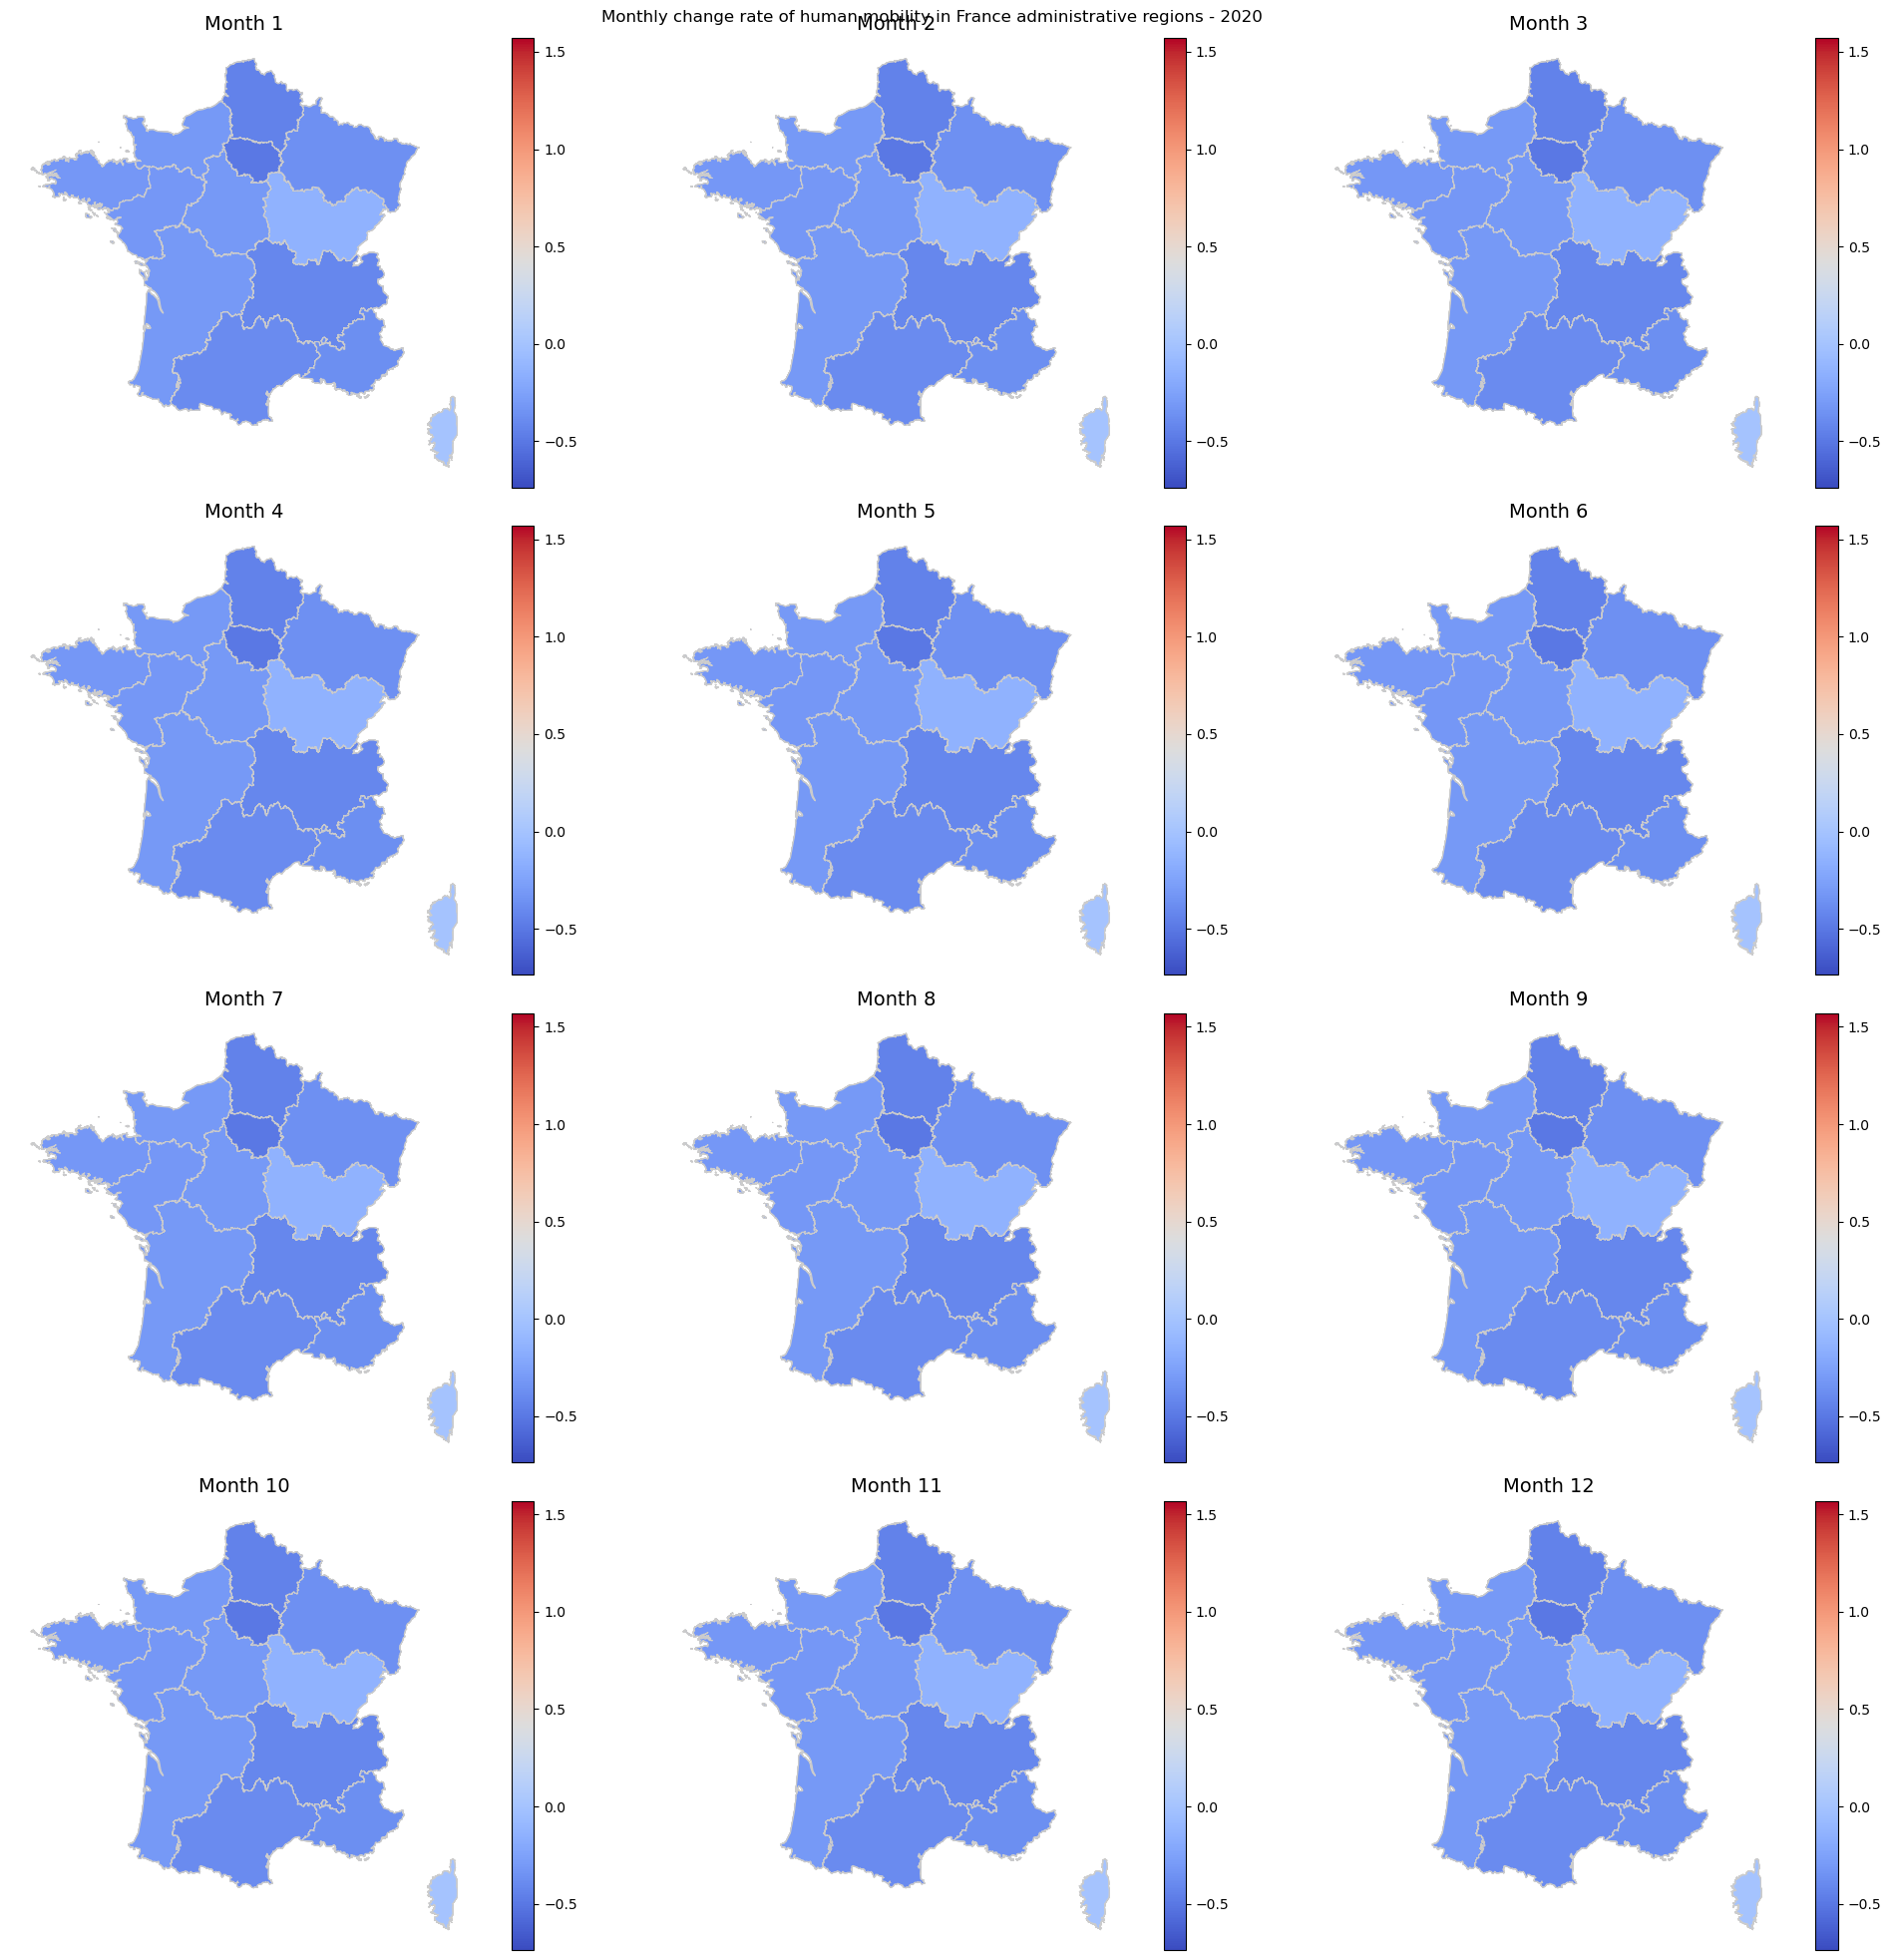

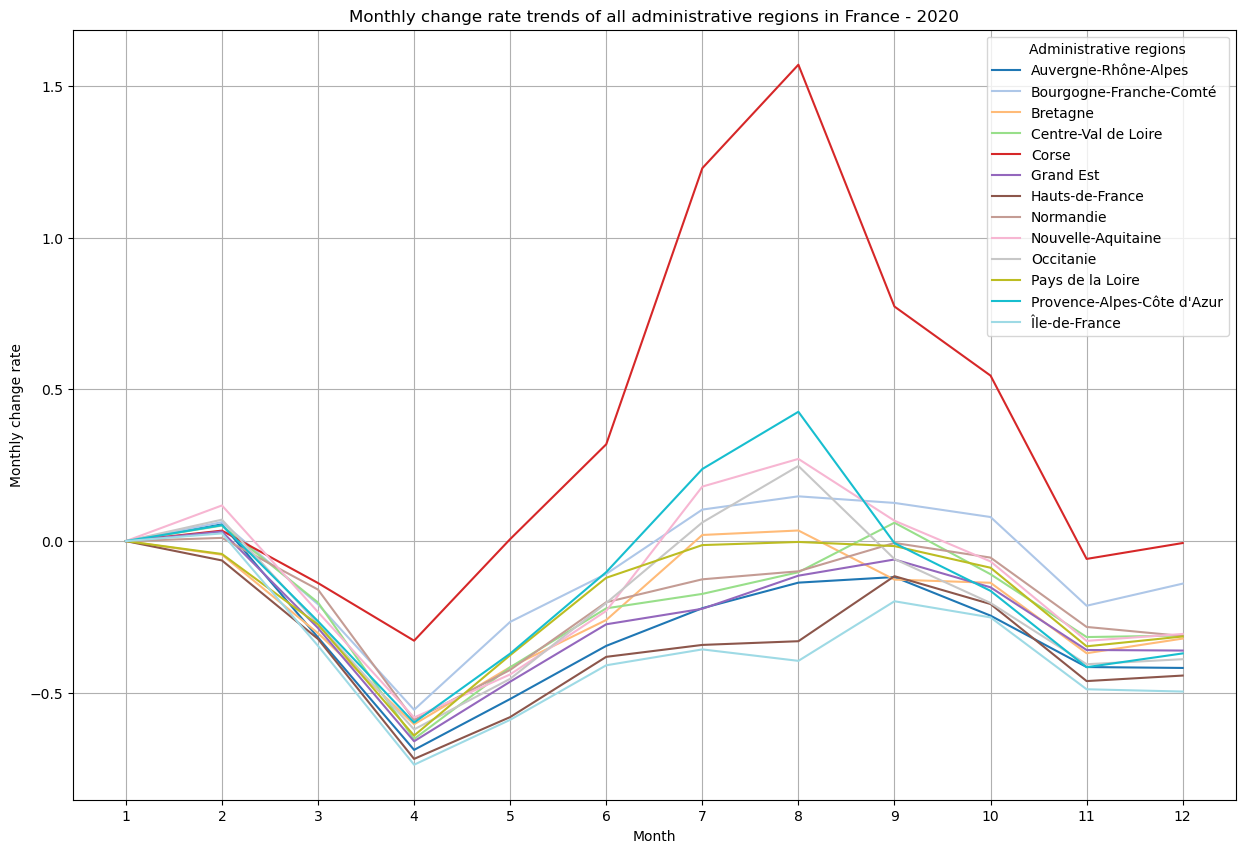



--------------- Done ---------------




import geopandas as gpd
import pandas as pd
import requests
from io import StringIO
import matplotlib.pyplot as plt
from tqdm import tqdm

def direct_solution():
    france_shp = "https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip"
    rest_api_url = "http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin=01/01/2020&end=12/31/2020"

    france_data = gpd.read_file(france_shp)
    rest_data = pd.read_csv(StringIO(requests.get(rest_api_url).text))
    rest_data_processed = rest_data[rest_data['place'].str.startswith('FRA')]

    january_data = rest_data_processed[pd.to_datetime(rest_data_processed['date']).dt.month == 1]
    january_data = january_data.groupby('place')['intra_movement',].mean().reset_index()
    
    monthly_change_rates = []

    for month in tqdm(range(1, 13), desc="Processing monthly mobility data"):
        monthly_data = rest_data_processed[pd.to_datetime(rest_data_processed['date']).dt.month == month]
        monthly_data = monthly_data.groupby('place')['intra_movement'].mean().reset_index()

        merged_data = monthly_data.merge(january_data, on='place', suffixes=('_current', '_january'))
        merged_data['monthly_change_rate'] = (merged_data['intra_movement_current'] - merged_data['intra_movement_january']) / merged_data['intra_movement_january']
        monthly_change_rates.append(merged_data)

    final_df = pd.concat(monthly_change_rates, keys=range(1, 13)).reset_index(level=0).rename(columns={'level_0': 'month'})

    france_data['GID_1'] = france_data['GID_1'].str.strip()
    final_df['place'] = final_df['place'].str.strip()

    france_data_merged = france_data.merge(final_df, left_on='GID_1', right_on='place')

    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20), sharex=True, sharey=True)

    for month, ax in zip(range(1, 13), axes.flatten()):
        france_data_merged.plot(column='monthly_change_rate', cmap='coolwarm', linewidth=0.8, edgecolor='0.8', legend=True, ax=ax)
        ax.set_title(f"Month {month}", fontsize=14)
        ax.axis("off")

    plt.suptitle("Monthly change rate of human mobility in France administrative regions - 2020")
    plt.tight_layout()

    line_chart_data = france_data_merged.pivot_table(values='monthly_change_rate', columns='NAME_1', index='month')

    line_chart_data.plot(figsize=(15, 10), cmap='tab20')
    plt.xlabel("Month")
    plt.ylabel("Monthly change rate")
    plt.title("Monthly change rate trends of all administrative regions in France - 2020")
    plt.xticks(range(1, 13))
    plt.legend(title="Administrative regions", loc='best')
    plt.grid(True)
    plt.show()


direct_solution()

In [46]:
direct_request_LLM_response = solution.get_direct_request_LLM_response()

clear_output(wait=True)
display(Code(solution.direct_request_code, language='python'))

code = solution.execute_complete_program(code=solution.direct_request_code, try_cnt=10)
# solution.direct_request_code = code
display(Code(code, language='python'))


In [47]:
# def execute_complete_program(self, code: str, try_cnt: int = 10) -> Optional[str]:
#     """
#     Execute a given program, retrying on exceptions.

#     Args:
#         code (str): The code to be executed.
#         try_cnt (int): Maximum number of execution attempts.

#     Returns:
#         Optional[str]: The last executed code or None in case of persistent failure.
#     """
#     count = 0
#     while count < try_cnt:
#         logging.info(f"Running code (trial # {count + 1}/{try_cnt})")
#         try:
#             count += 1
#             exec(code)
#             logging.info("Execution succeeded")
#             return code
#         except Exception as e:
#             logging.error(f"An error occurred: {e}")
#             debug_prompt = self.get_debug_prompt(exception=e, code=self.direct_request_code)
#             logging.info("Sending error information to LLM for debugging")
#             response = helper.get_LLM_reply(prompt=debug_prompt,
#                                             system_role=constants.debug_role,
#                                             model=self.model,
#                                             verbose=True,
#                                             stream=True,
#                                             retry_cnt=3)
#             code = helper.extract_code(response)
#     logging.error("Maximum retry attempts exceeded, rethrowing last exception")
#     raise e  # Rethrow the last exception